In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy.stats import norm, linregress

import os
import time
import itertools

from glove.log_model import *

from sklearn.model_selection import KFold

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-417ev842 because the default path (/home/jaron/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# import file names
files = os.listdir("data/")
files = [f for f in files if "processed" in f]
files

['EXP0019_MS001_processed.csv',
 'EXP0019_DSM27147_processed.csv',
 'EXP0019_MS008_processed.csv',
 'EXP0019_MS014_processed.csv']

# Function to make predictions on test data

In [3]:
def predict_df(model, df, species):
    
    # save measured and predicted values
    pred_species = []
    pred = []
    stdv = []
    true = []

    # pull just the community data
    test_data = process_df(df, species) 

    # plot the results
    for exp, t_span, Y_m, s_present in test_data:

        # increase evaluation time
        t_eval = np.linspace(t_span[0], t_span[-1])

        # predict 
        Y_p, L, U = model.predict(Y_m, t_eval, log=True)
        Y_std = U - Y_p
        
        # un log scale y
        Y_m = np.einsum("ij,j->ij", np.exp(Y_m), s_present)

        ### append only end-point prediction results for non-zero outcomes ###
        inds_pos = Y_m[-1,:] > 0 
        pred_species.append(np.array(species)[inds_pos])
        true.append(Y_m[-1,:][inds_pos])
        pred.append(Y_p[-1,:][inds_pos])
        stdv.append(Y_std[-1,:][inds_pos])
        
    # concatenate list
    pred_species = np.concatenate(pred_species)
    true = np.concatenate(true)
    pred = np.concatenate(pred)
    stdv = np.concatenate(stdv)
        
    return pred_species, true, pred, stdv

In [4]:
# run kfold for each file 
for file in files:
    
    # import data
    df = pd.read_csv(f"data/{file}")

    # determine species names 
    species = df.columns.values[2:]

    # separate mono culture data 
    # mono_df = pd.concat([df_i for name, df_i in df.groupby("Treatments") if "Mono" in name])
    dfs = [df_i for name, df_i in df.groupby("Treatments") if "Mono" not in name]

    # init kfold object
    kf = KFold(n_splits=20, shuffle=True, random_state=21)

    # keep track of all predictions
    all_pred_species = []
    all_true = []
    all_pred = []
    all_stdv = []

    # run Kfold 
    # train_index, test_index = next(iter(kf.split(dfs)))
    for train_index, test_index in kf.split(dfs):

        # get train df 
        train_df = pd.concat([dfs[i] for i in train_index])
        # train_df = pd.concat((mono_df, train_df))

        # get test df
        test_df = pd.concat([dfs[i] for i in test_index])

        # instantiate gLV fit 
        model = gLV(species, train_df)

        # fit to data 
        model.fit() 

        # plot fitness to data
        pred_species, true, pred, stdv = predict_df(model, test_df, species)

        # append predictions 
        all_pred_species = np.append(all_pred_species, pred_species)
        all_true = np.append(all_true, true)
        all_pred = np.append(all_pred, pred)
        all_stdv = np.append(all_stdv, stdv)

    # save prediction results to a .csv
    strain = file.split("_")[1]
    kfold_df = pd.DataFrame()
    kfold_df['species'] = all_pred_species
    kfold_df['true'] = all_true
    kfold_df['pred'] = all_pred
    kfold_df['stdv'] = all_stdv
    kfold_df.to_csv(f"kfold/{strain}_kfold.csv", index=False)
        
    # show prediction performance of individual species
    for sp in species:
        sp_inds = all_pred_species == sp
        R = linregress(all_true[sp_inds], all_pred[sp_inds]).rvalue
        plt.scatter(all_true[sp_inds], all_pred[sp_inds], label=f"{sp} " + "R={:.3f}".format(R))
        plt.errorbar(all_true[sp_inds], all_pred[sp_inds], yerr=all_stdv[sp_inds], 
                     fmt='.', capsize=3)

    plt.xlabel("Measured OD")
    plt.ylabel("Predicted OD")
    plt.legend()
    plt.title(strain)
    plt.savefig(f"kfold/{strain}_kfold.pdf", dpi=300)
    plt.show()

Total samples: 38, Updated regularization: 1.00e-05
Loss: 410.838, Residuals: -1.920
Loss: 308.875, Residuals: -1.482
Loss: 271.141, Residuals: -0.766
Loss: 247.717, Residuals: 0.412
Loss: 194.458, Residuals: 0.024
Loss: 181.162, Residuals: -0.005
Loss: 177.343, Residuals: 0.361
Loss: 170.099, Residuals: 0.303
Loss: 157.177, Residuals: 0.188
Loss: 142.462, Residuals: 0.443
Loss: 137.660, Residuals: 0.735
Loss: 128.928, Residuals: 0.656
Loss: 121.618, Residuals: 0.051
Loss: 120.840, Residuals: 0.178
Loss: 114.334, Residuals: 0.164
Loss: 111.436, Residuals: 0.661
Loss: 111.329, Residuals: 0.634
Loss: 107.368, Residuals: 0.558
Loss: 101.672, Residuals: 0.357
Loss: 101.430, Residuals: 0.375
Loss: 99.204, Residuals: 0.308
Loss: 95.390, Residuals: 0.190
Loss: 95.028, Residuals: 0.219
Loss: 92.085, Residuals: 0.151
Loss: 92.030, Residuals: 0.126
Loss: 91.927, Residuals: 0.136
Loss: 91.737, Residuals: 0.150
Loss: 90.044, Residuals: 0.140
Loss: 89.991, Residuals: 0.096
Loss: 89.533, Residuals: 

Loss: 146.754, Residuals: 0.434
Loss: 146.390, Residuals: 0.431
Loss: 145.805, Residuals: 0.441
Loss: 144.888, Residuals: 0.508
Loss: 144.672, Residuals: 0.480
Loss: 144.623, Residuals: 0.475
Loss: 144.200, Residuals: 0.504
Loss: 144.191, Residuals: 0.503
Loss: 144.107, Residuals: 0.506
Loss: 144.021, Residuals: 0.499
Loss: 144.012, Residuals: 0.491
Loss: 143.665, Residuals: 0.518
Loss: 143.659, Residuals: 0.510
Loss: 143.419, Residuals: 0.530
Loss: 143.394, Residuals: 0.514
Loss: 143.346, Residuals: 0.511
Loss: 143.260, Residuals: 0.503
Loss: 143.105, Residuals: 0.490
Loss: 143.096, Residuals: 0.476
Loss: 142.747, Residuals: 0.493
Loss: 142.721, Residuals: 0.477
Loss: 142.486, Residuals: 0.468
Loss: 142.476, Residuals: 0.453
Loss: 142.088, Residuals: 0.473
Loss: 141.950, Residuals: 0.447
Loss: 141.747, Residuals: 0.420
Loss: 141.395, Residuals: 0.400
Loss: 141.382, Residuals: 0.381
Loss: 140.890, Residuals: 0.413
Loss: 140.758, Residuals: 0.419
Loss: 140.516, Residuals: 0.427
Loss: 14

Loss: 189.207, Residuals: 0.051
Loss: 174.417, Residuals: -0.034
Loss: 170.982, Residuals: 0.275
Loss: 143.163, Residuals: 0.085
Loss: 137.661, Residuals: 0.133
Loss: 127.317, Residuals: 0.217
Loss: 121.879, Residuals: 0.261
Loss: 113.380, Residuals: 0.140
Loss: 112.542, Residuals: 0.291
Loss: 105.964, Residuals: 0.306
Loss: 105.544, Residuals: 0.276
Loss: 104.774, Residuals: 0.333
Loss: 98.766, Residuals: 0.263
Loss: 98.721, Residuals: 0.237
Loss: 98.308, Residuals: 0.276
Loss: 94.775, Residuals: 0.213
Loss: 94.011, Residuals: 0.327
Loss: 93.965, Residuals: 0.358
Loss: 92.215, Residuals: 0.317
Loss: 92.196, Residuals: 0.276
Loss: 89.512, Residuals: 0.234
Loss: 89.484, Residuals: 0.213
Loss: 89.237, Residuals: 0.221
Loss: 88.772, Residuals: 0.222
Loss: 87.887, Residuals: 0.204
Loss: 87.450, Residuals: 0.210
Loss: 86.747, Residuals: 0.220
Loss: 85.455, Residuals: 0.200
Loss: 85.452, Residuals: 0.193
Loss: 85.423, Residuals: 0.200
Loss: 84.279, Residuals: 0.195
Loss: 84.267, Residuals: 0

Loss: 143.261, Residuals: 0.471
Loss: 142.881, Residuals: 0.478
Loss: 142.876, Residuals: 0.485
Loss: 142.711, Residuals: 0.487
Loss: 142.503, Residuals: 0.499
Loss: 142.501, Residuals: 0.504
Loss: 142.496, Residuals: 0.501
Loss: 142.489, Residuals: 0.496
Loss: 142.477, Residuals: 0.491
Loss: 142.467, Residuals: 0.488
Loss: 142.466, Residuals: 0.488
Loss: 142.457, Residuals: 0.489
Loss: 142.445, Residuals: 0.492
Loss: 142.444, Residuals: 0.492
Loss: 142.443, Residuals: 0.492
Loss: 142.442, Residuals: 0.492
Loss: 142.439, Residuals: 0.493
Loss: 142.439, Residuals: 0.493
Loss: 142.439, Residuals: 0.492
Loss: 142.438, Residuals: 0.492
Loss: 142.437, Residuals: 0.492
Loss: 142.437, Residuals: 0.492
Evidence -101.889
Updating hyper-parameters...
Total samples: 38, Updated regularization: 3.69e-01
Loss: 146.514, Residuals: 0.432
Loss: 146.290, Residuals: 0.448
Loss: 145.897, Residuals: 0.476
Loss: 145.398, Residuals: 0.534
Loss: 145.388, Residuals: 0.533
Loss: 145.370, Residuals: 0.530
Loss:

Loss: 151.494, Residuals: 0.479
Loss: 151.494, Residuals: 0.478
Loss: 151.494, Residuals: 0.478
Loss: 151.494, Residuals: 0.478
Loss: 151.493, Residuals: 0.477
Loss: 151.493, Residuals: 0.477
Evidence -86.850
Updating hyper-parameters...
Total samples: 38, Updated regularization: 5.50e-01
Loss: 151.571, Residuals: 0.477
Loss: 151.571, Residuals: 0.475
Loss: 151.570, Residuals: 0.477
Loss: 151.568, Residuals: 0.477
Loss: 151.567, Residuals: 0.477
Loss: 151.567, Residuals: 0.477
Evidence -86.777
Pass count  1
Total samples: 40, Updated regularization: 1.00e-05
Loss: 408.233, Residuals: -1.839
Loss: 303.425, Residuals: -1.947
Loss: 262.178, Residuals: -0.207
Loss: 254.220, Residuals: 0.451
Loss: 187.481, Residuals: -0.394
Loss: 179.401, Residuals: -0.031
Loss: 165.393, Residuals: 0.156
Loss: 143.518, Residuals: 0.279
Loss: 138.150, Residuals: 0.245
Loss: 128.456, Residuals: 0.201
Loss: 116.898, Residuals: 0.295
Loss: 116.087, Residuals: 0.388
Loss: 109.478, Residuals: 0.357
Loss: 107.957,

Loss: 145.690, Residuals: 0.295
Loss: 145.661, Residuals: 0.299
Loss: 145.617, Residuals: 0.307
Loss: 145.612, Residuals: 0.307
Loss: 145.610, Residuals: 0.304
Loss: 145.596, Residuals: 0.306
Loss: 145.575, Residuals: 0.310
Loss: 145.575, Residuals: 0.310
Loss: 145.574, Residuals: 0.309
Loss: 145.573, Residuals: 0.308
Loss: 145.573, Residuals: 0.307
Loss: 145.567, Residuals: 0.309
Loss: 145.557, Residuals: 0.313
Loss: 145.557, Residuals: 0.313
Loss: 145.551, Residuals: 0.315
Loss: 145.551, Residuals: 0.315
Loss: 145.548, Residuals: 0.317
Loss: 145.547, Residuals: 0.317
Loss: 145.547, Residuals: 0.317
Evidence -82.093
Updating hyper-parameters...
Total samples: 40, Updated regularization: 2.78e-01
Loss: 150.774, Residuals: 0.275
Loss: 150.416, Residuals: 0.284
Loss: 150.162, Residuals: 0.307
Loss: 150.154, Residuals: 0.309
Loss: 150.080, Residuals: 0.312
Loss: 149.969, Residuals: 0.322
Loss: 149.962, Residuals: 0.316
Loss: 149.948, Residuals: 0.317
Loss: 149.924, Residuals: 0.319
Loss: 

Loss: 84.899, Residuals: 0.075
Loss: 84.490, Residuals: 0.078
Loss: 83.806, Residuals: 0.065
Loss: 83.773, Residuals: 0.082
Loss: 83.715, Residuals: 0.091
Loss: 83.176, Residuals: 0.083
Loss: 83.168, Residuals: 0.063
Loss: 81.972, Residuals: 0.060
Loss: 81.959, Residuals: 0.048
Loss: 81.942, Residuals: 0.032
Loss: 81.796, Residuals: 0.050
Loss: 80.646, Residuals: 0.056
Loss: 80.631, Residuals: 0.042
Loss: 80.609, Residuals: 0.026
Loss: 80.571, Residuals: 0.033
Loss: 80.509, Residuals: 0.035
Loss: 80.392, Residuals: 0.035
Loss: 80.227, Residuals: 0.064
Loss: 80.206, Residuals: 0.076
Loss: 79.465, Residuals: 0.076
Loss: 79.463, Residuals: 0.071
Loss: 79.460, Residuals: 0.066
Loss: 79.456, Residuals: 0.056
Loss: 78.915, Residuals: 0.056
Loss: 78.912, Residuals: 0.047
Loss: 78.887, Residuals: 0.047
Loss: 78.840, Residuals: 0.045
Loss: 78.751, Residuals: 0.043
Loss: 78.684, Residuals: 0.056
Loss: 78.565, Residuals: 0.050
Loss: 78.556, Residuals: 0.052
Loss: 78.212, Residuals: 0.052
Loss: 78

Loss: 141.445, Residuals: 0.273
Loss: 141.441, Residuals: 0.274
Loss: 141.438, Residuals: 0.275
Loss: 141.409, Residuals: 0.278
Loss: 141.390, Residuals: 0.285
Loss: 141.388, Residuals: 0.285
Loss: 141.387, Residuals: 0.285
Loss: 141.387, Residuals: 0.284
Loss: 141.386, Residuals: 0.285
Loss: 141.386, Residuals: 0.285
Loss: 141.386, Residuals: 0.286
Loss: 141.386, Residuals: 0.286
Loss: 141.386, Residuals: 0.287
Loss: 141.386, Residuals: 0.287
Evidence -113.191
Updating hyper-parameters...
Total samples: 40, Updated regularization: 1.28e+00
Loss: 149.615, Residuals: 0.175
Loss: 148.591, Residuals: 0.206
Loss: 147.407, Residuals: 0.256
Loss: 147.345, Residuals: 0.258
Loss: 147.230, Residuals: 0.259
Loss: 147.042, Residuals: 0.263
Loss: 147.013, Residuals: 0.264
Loss: 146.959, Residuals: 0.267
Loss: 146.881, Residuals: 0.275
Loss: 146.876, Residuals: 0.279
Loss: 146.867, Residuals: 0.280
Loss: 146.851, Residuals: 0.283
Loss: 146.850, Residuals: 0.282
Loss: 146.842, Residuals: 0.284
Loss:

Loss: 75.795, Residuals: 0.073
Loss: 75.696, Residuals: 0.078
Loss: 75.539, Residuals: 0.087
Loss: 75.537, Residuals: 0.089
Loss: 75.142, Residuals: 0.085
Loss: 75.141, Residuals: 0.083
Loss: 74.472, Residuals: 0.085
Loss: 74.470, Residuals: 0.080
Loss: 74.467, Residuals: 0.075
Loss: 74.443, Residuals: 0.076
Loss: 74.422, Residuals: 0.074
Loss: 74.407, Residuals: 0.078
Loss: 74.276, Residuals: 0.069
Loss: 74.269, Residuals: 0.077
Loss: 74.000, Residuals: 0.076
Loss: 73.999, Residuals: 0.070
Loss: 73.566, Residuals: 0.073
Loss: 73.566, Residuals: 0.069
Evidence -542.066
Updating hyper-parameters...
Total samples: 40, Updated regularization: 2.54e-02
Loss: 107.333, Residuals: 0.011
Loss: 107.088, Residuals: -0.019
Loss: 105.101, Residuals: -0.013
Loss: 105.079, Residuals: -0.002
Loss: 104.245, Residuals: 0.006
Loss: 102.853, Residuals: 0.012
Loss: 102.682, Residuals: 0.005
Loss: 101.414, Residuals: 0.028
Loss: 101.387, Residuals: 0.027
Loss: 101.343, Residuals: 0.034
Loss: 100.939, Resid

Loss: 153.661, Residuals: 0.557
Loss: 153.563, Residuals: 0.567
Loss: 153.479, Residuals: 0.599
Loss: 153.474, Residuals: 0.599
Loss: 153.468, Residuals: 0.595
Loss: 153.458, Residuals: 0.595
Loss: 153.451, Residuals: 0.594
Loss: 153.451, Residuals: 0.593
Loss: 153.450, Residuals: 0.592
Loss: 153.449, Residuals: 0.592
Loss: 153.448, Residuals: 0.591
Loss: 153.448, Residuals: 0.591
Loss: 153.448, Residuals: 0.591
Evidence -87.419
Updating hyper-parameters...
Total samples: 40, Updated regularization: 1.21e+00
Loss: 154.474, Residuals: 0.593
Loss: 154.424, Residuals: 0.605
Loss: 154.402, Residuals: 0.613
Loss: 154.396, Residuals: 0.609
Loss: 154.392, Residuals: 0.609
Loss: 154.392, Residuals: 0.609
Loss: 154.392, Residuals: 0.610
Loss: 154.391, Residuals: 0.610
Loss: 154.391, Residuals: 0.609
Loss: 154.391, Residuals: 0.607
Loss: 154.391, Residuals: 0.607
Evidence -86.588
Updating hyper-parameters...
Total samples: 40, Updated regularization: 1.21e+00
Loss: 155.074, Residuals: 0.606
Loss

Loss: 116.661, Residuals: 0.086
Loss: 114.970, Residuals: 0.127
Loss: 114.966, Residuals: 0.128
Loss: 114.958, Residuals: 0.130
Loss: 114.945, Residuals: 0.132
Loss: 113.182, Residuals: 0.149
Loss: 113.120, Residuals: 0.129
Loss: 113.093, Residuals: 0.138
Loss: 113.055, Residuals: 0.147
Loss: 112.982, Residuals: 0.148
Loss: 112.846, Residuals: 0.146
Loss: 112.834, Residuals: 0.150
Loss: 112.382, Residuals: 0.156
Loss: 112.380, Residuals: 0.153
Loss: 112.361, Residuals: 0.157
Loss: 112.326, Residuals: 0.157
Loss: 112.008, Residuals: 0.161
Loss: 112.007, Residuals: 0.159
Evidence -128.497
Updating hyper-parameters...
Total samples: 37, Updated regularization: 1.23e-01
Loss: 134.084, Residuals: 0.132
Loss: 133.867, Residuals: 0.127
Loss: 133.455, Residuals: 0.122
Loss: 132.712, Residuals: 0.121
Loss: 131.556, Residuals: 0.128
Loss: 131.551, Residuals: 0.127
Loss: 130.708, Residuals: 0.140
Loss: 129.270, Residuals: 0.179
Loss: 129.261, Residuals: 0.174
Loss: 129.252, Residuals: 0.175
Loss:

Loss: 104.257, Residuals: 0.325
Loss: 103.804, Residuals: 0.401
Loss: 100.034, Residuals: 0.346
Loss: 99.926, Residuals: 0.321
Loss: 96.219, Residuals: 0.262
Loss: 96.186, Residuals: 0.242
Loss: 95.897, Residuals: 0.265
Loss: 93.517, Residuals: 0.190
Loss: 93.074, Residuals: 0.286
Loss: 92.232, Residuals: 0.262
Loss: 92.222, Residuals: 0.264
Loss: 90.809, Residuals: 0.225
Loss: 90.805, Residuals: 0.218
Loss: 88.573, Residuals: 0.165
Loss: 88.547, Residuals: 0.147
Loss: 88.508, Residuals: 0.126
Loss: 88.212, Residuals: 0.127
Loss: 85.860, Residuals: 0.103
Loss: 85.818, Residuals: 0.079
Loss: 85.762, Residuals: 0.050
Loss: 85.659, Residuals: 0.063
Loss: 85.465, Residuals: 0.069
Loss: 85.112, Residuals: 0.074
Loss: 84.945, Residuals: 0.141
Loss: 84.943, Residuals: 0.142
Loss: 83.494, Residuals: 0.121
Loss: 83.429, Residuals: 0.125
Loss: 82.925, Residuals: 0.118
Loss: 82.788, Residuals: 0.113
Loss: 81.641, Residuals: 0.100
Loss: 81.548, Residuals: 0.124
Loss: 80.666, Residuals: 0.117
Loss:

Loss: 148.906, Residuals: 0.367
Loss: 148.902, Residuals: 0.362
Loss: 148.896, Residuals: 0.362
Loss: 148.883, Residuals: 0.364
Loss: 148.883, Residuals: 0.364
Loss: 148.869, Residuals: 0.367
Loss: 148.869, Residuals: 0.366
Evidence -93.335
Updating hyper-parameters...
Total samples: 40, Updated regularization: 1.19e+00
Loss: 153.319, Residuals: 0.355
Loss: 153.033, Residuals: 0.344
Loss: 152.688, Residuals: 0.384
Loss: 152.504, Residuals: 0.389
Loss: 152.497, Residuals: 0.402
Loss: 152.485, Residuals: 0.401
Loss: 152.461, Residuals: 0.401
Loss: 152.419, Residuals: 0.401
Loss: 152.374, Residuals: 0.398
Loss: 152.370, Residuals: 0.396
Loss: 152.366, Residuals: 0.398
Loss: 152.365, Residuals: 0.398
Loss: 152.360, Residuals: 0.398
Loss: 152.360, Residuals: 0.399
Loss: 152.357, Residuals: 0.399
Loss: 152.353, Residuals: 0.399
Loss: 152.353, Residuals: 0.398
Loss: 152.353, Residuals: 0.398
Loss: 152.352, Residuals: 0.399
Loss: 152.351, Residuals: 0.399
Loss: 152.351, Residuals: 0.399
Eviden

Loss: 148.670, Residuals: 0.307
Loss: 148.667, Residuals: 0.305
Loss: 148.662, Residuals: 0.305
Loss: 148.618, Residuals: 0.311
Loss: 148.564, Residuals: 0.318
Loss: 148.467, Residuals: 0.316
Loss: 148.327, Residuals: 0.312
Loss: 148.326, Residuals: 0.313
Loss: 148.313, Residuals: 0.313
Loss: 148.292, Residuals: 0.314
Loss: 148.290, Residuals: 0.311
Loss: 148.281, Residuals: 0.311
Loss: 148.279, Residuals: 0.310
Loss: 148.275, Residuals: 0.311
Loss: 148.270, Residuals: 0.311
Loss: 148.270, Residuals: 0.311
Loss: 148.270, Residuals: 0.311
Loss: 148.269, Residuals: 0.312
Loss: 148.269, Residuals: 0.312
Evidence -112.661
Updating hyper-parameters...
Total samples: 38, Updated regularization: 1.09e+00
Loss: 149.625, Residuals: 0.316
Loss: 149.556, Residuals: 0.311
Loss: 149.480, Residuals: 0.307
Loss: 149.480, Residuals: 0.307
Evidence -111.171
Updating hyper-parameters...
Total samples: 38, Updated regularization: 1.13e+00
Loss: 150.182, Residuals: 0.304
Loss: 150.115, Residuals: 0.306
Lo

Loss: 75.637, Residuals: 0.102
Loss: 73.441, Residuals: 0.087
Loss: 70.369, Residuals: 0.090
Loss: 70.134, Residuals: 0.146
Loss: 68.109, Residuals: 0.090
Loss: 67.522, Residuals: 0.097
Loss: 63.815, Residuals: 0.110
Loss: 63.338, Residuals: 0.139
Loss: 62.497, Residuals: 0.122
Loss: 61.430, Residuals: 0.070
Loss: 61.109, Residuals: 0.092
Loss: 60.547, Residuals: 0.121
Loss: 59.787, Residuals: 0.163
Loss: 59.673, Residuals: 0.168
Loss: 58.593, Residuals: 0.141
Loss: 58.541, Residuals: 0.164
Loss: 56.634, Residuals: 0.109
Loss: 56.596, Residuals: 0.116
Loss: 55.373, Residuals: 0.119
Loss: 55.320, Residuals: 0.148
Loss: 55.234, Residuals: 0.160
Loss: 54.431, Residuals: 0.148
Loss: 54.388, Residuals: 0.156
Loss: 52.873, Residuals: 0.121
Loss: 52.796, Residuals: 0.134
Loss: 52.653, Residuals: 0.140
Loss: 52.390, Residuals: 0.128
Loss: 52.281, Residuals: 0.169
Loss: 51.357, Residuals: 0.136
Loss: 51.320, Residuals: 0.145
Loss: 51.034, Residuals: 0.119
Loss: 50.983, Residuals: 0.147
Loss: 50

Loss: 136.969, Residuals: 0.201
Loss: 136.604, Residuals: 0.217
Loss: 136.569, Residuals: 0.206
Loss: 136.551, Residuals: 0.215
Loss: 136.518, Residuals: 0.215
Loss: 136.466, Residuals: 0.217
Loss: 136.451, Residuals: 0.210
Loss: 136.425, Residuals: 0.212
Loss: 136.400, Residuals: 0.212
Loss: 136.399, Residuals: 0.213
Loss: 136.397, Residuals: 0.212
Loss: 136.396, Residuals: 0.213
Loss: 136.396, Residuals: 0.213
Loss: 136.394, Residuals: 0.213
Loss: 136.393, Residuals: 0.212
Loss: 136.393, Residuals: 0.212
Loss: 136.393, Residuals: 0.212
Loss: 136.393, Residuals: 0.212
Loss: 136.393, Residuals: 0.212
Evidence -49.513
Updating hyper-parameters...
Total samples: 37, Updated regularization: 1.42e+00
Loss: 140.620, Residuals: 0.211
Loss: 140.005, Residuals: 0.206
Loss: 139.883, Residuals: 0.207
Loss: 139.658, Residuals: 0.213
Loss: 139.304, Residuals: 0.225
Loss: 139.288, Residuals: 0.218
Loss: 139.155, Residuals: 0.221
Loss: 139.019, Residuals: 0.226
Loss: 139.005, Residuals: 0.228
Loss: 

Loss: 193.663, Residuals: -0.018
Loss: 181.267, Residuals: -0.094
Loss: 178.878, Residuals: 0.220
Loss: 159.346, Residuals: -0.002
Loss: 155.366, Residuals: 0.069
Loss: 147.796, Residuals: 0.065
Loss: 134.559, Residuals: 0.136
Loss: 129.654, Residuals: 0.107
Loss: 122.147, Residuals: 0.233
Loss: 121.362, Residuals: 0.324
Loss: 119.861, Residuals: 0.351
Loss: 117.161, Residuals: 0.390
Loss: 112.526, Residuals: 0.368
Loss: 111.838, Residuals: 0.440
Loss: 106.437, Residuals: 0.393
Loss: 106.293, Residuals: 0.359
Loss: 106.017, Residuals: 0.371
Loss: 103.642, Residuals: 0.327
Loss: 102.877, Residuals: 0.385
Loss: 101.435, Residuals: 0.349
Loss: 98.886, Residuals: 0.287
Loss: 98.849, Residuals: 0.272
Loss: 97.387, Residuals: 0.248
Loss: 95.192, Residuals: 0.205
Loss: 94.726, Residuals: 0.265
Loss: 91.115, Residuals: 0.198
Loss: 91.058, Residuals: 0.173
Loss: 91.018, Residuals: 0.171
Loss: 89.519, Residuals: 0.148
Loss: 89.310, Residuals: 0.164
Loss: 87.555, Residuals: 0.150
Loss: 87.542, Re

Loss: 121.443, Residuals: 0.214
Loss: 121.443, Residuals: 0.214
Loss: 121.443, Residuals: 0.214
Loss: 121.443, Residuals: 0.214
Loss: 121.443, Residuals: 0.214
Loss: 121.443, Residuals: 0.214
Evidence -162.198
Updating hyper-parameters...
Total samples: 40, Updated regularization: 2.70e-01
Loss: 140.599, Residuals: 0.163
Loss: 139.748, Residuals: 0.127
Loss: 138.856, Residuals: 0.082
Loss: 138.850, Residuals: 0.090
Loss: 137.834, Residuals: 0.120
Loss: 136.175, Residuals: 0.193
Loss: 135.732, Residuals: 0.247
Loss: 135.712, Residuals: 0.227
Loss: 135.675, Residuals: 0.229
Loss: 135.323, Residuals: 0.239
Loss: 134.706, Residuals: 0.264
Loss: 134.670, Residuals: 0.268
Loss: 134.663, Residuals: 0.264
Loss: 134.356, Residuals: 0.275
Loss: 133.859, Residuals: 0.305
Loss: 133.856, Residuals: 0.305
Loss: 133.834, Residuals: 0.306
Loss: 133.646, Residuals: 0.313
Loss: 133.609, Residuals: 0.316
Loss: 133.599, Residuals: 0.309
Loss: 133.596, Residuals: 0.311
Loss: 133.563, Residuals: 0.312
Loss:

Loss: 106.854, Residuals: 0.503
Loss: 103.309, Residuals: 0.438
Loss: 103.264, Residuals: 0.425
Loss: 101.511, Residuals: 0.384
Loss: 98.470, Residuals: 0.311
Loss: 97.825, Residuals: 0.385
Loss: 96.602, Residuals: 0.339
Loss: 94.409, Residuals: 0.262
Loss: 93.186, Residuals: 0.246
Loss: 93.110, Residuals: 0.264
Loss: 90.425, Residuals: 0.205
Loss: 90.381, Residuals: 0.175
Loss: 88.751, Residuals: 0.150
Loss: 88.745, Residuals: 0.142
Loss: 87.693, Residuals: 0.128
Loss: 87.394, Residuals: 0.218
Loss: 87.289, Residuals: 0.221
Loss: 86.305, Residuals: 0.199
Loss: 84.611, Residuals: 0.175
Loss: 84.594, Residuals: 0.159
Loss: 84.570, Residuals: 0.140
Loss: 84.351, Residuals: 0.141
Loss: 83.971, Residuals: 0.142
Loss: 83.959, Residuals: 0.154
Loss: 82.175, Residuals: 0.155
Loss: 82.158, Residuals: 0.139
Loss: 82.132, Residuals: 0.121
Loss: 82.085, Residuals: 0.128
Loss: 82.012, Residuals: 0.144
Loss: 79.590, Residuals: 0.150
Loss: 79.520, Residuals: 0.117
Loss: 79.406, Residuals: 0.114
Loss

Loss: 141.240, Residuals: 0.530
Loss: 141.240, Residuals: 0.531
Loss: 141.240, Residuals: 0.530
Loss: 141.237, Residuals: 0.532
Loss: 141.237, Residuals: 0.532
Evidence -105.450
Updating hyper-parameters...
Total samples: 38, Updated regularization: 1.21e-01
Loss: 147.530, Residuals: 0.490
Loss: 147.158, Residuals: 0.479
Loss: 146.578, Residuals: 0.454
Loss: 146.515, Residuals: 0.480
Loss: 146.001, Residuals: 0.499
Loss: 145.989, Residuals: 0.487
Loss: 145.550, Residuals: 0.515
Loss: 145.543, Residuals: 0.512
Loss: 145.478, Residuals: 0.505
Loss: 144.915, Residuals: 0.528
Loss: 144.906, Residuals: 0.524
Loss: 144.831, Residuals: 0.519
Loss: 144.799, Residuals: 0.505
Loss: 144.522, Residuals: 0.520
Loss: 144.515, Residuals: 0.517
Loss: 144.454, Residuals: 0.507
Loss: 144.379, Residuals: 0.499
Loss: 144.373, Residuals: 0.491
Loss: 144.138, Residuals: 0.504
Loss: 144.136, Residuals: 0.503
Loss: 143.865, Residuals: 0.519
Loss: 143.861, Residuals: 0.516
Loss: 143.851, Residuals: 0.516
Loss:

Loss: 151.304, Residuals: 0.450
Loss: 151.304, Residuals: 0.449
Loss: 151.303, Residuals: 0.449
Loss: 151.303, Residuals: 0.449
Evidence -85.961
Updating hyper-parameters...
Total samples: 38, Updated regularization: 3.21e-01
Loss: 151.511, Residuals: 0.436
Loss: 151.494, Residuals: 0.439
Loss: 151.492, Residuals: 0.437
Loss: 151.478, Residuals: 0.442
Loss: 151.456, Residuals: 0.451
Loss: 151.456, Residuals: 0.451
Loss: 151.455, Residuals: 0.450
Loss: 151.449, Residuals: 0.453
Loss: 151.449, Residuals: 0.451
Loss: 151.443, Residuals: 0.453
Loss: 151.443, Residuals: 0.453
Loss: 151.442, Residuals: 0.453
Loss: 151.439, Residuals: 0.454
Loss: 151.439, Residuals: 0.453
Loss: 151.438, Residuals: 0.454
Loss: 151.438, Residuals: 0.452
Loss: 151.437, Residuals: 0.453
Loss: 151.437, Residuals: 0.452
Evidence -85.781
Updating hyper-parameters...
Total samples: 38, Updated regularization: 3.32e-01
Loss: 151.593, Residuals: 0.438
Loss: 151.581, Residuals: 0.438
Loss: 151.578, Residuals: 0.440
Loss

Loss: 134.059, Residuals: 0.267
Loss: 134.058, Residuals: 0.267
Loss: 134.058, Residuals: 0.268
Loss: 134.057, Residuals: 0.268
Loss: 134.057, Residuals: 0.268
Loss: 134.057, Residuals: 0.268
Loss: 134.057, Residuals: 0.268
Evidence -131.844
Updating hyper-parameters...
Total samples: 40, Updated regularization: 5.09e-01
Loss: 147.286, Residuals: 0.259
Loss: 146.896, Residuals: 0.259
Loss: 146.244, Residuals: 0.259
Loss: 146.135, Residuals: 0.262
Loss: 145.196, Residuals: 0.303
Loss: 144.100, Residuals: 0.402
Loss: 144.078, Residuals: 0.404
Loss: 144.038, Residuals: 0.403
Loss: 143.962, Residuals: 0.400
Loss: 143.870, Residuals: 0.397
Loss: 143.705, Residuals: 0.394
Loss: 143.454, Residuals: 0.391
Loss: 143.430, Residuals: 0.376
Loss: 143.389, Residuals: 0.380
Loss: 143.325, Residuals: 0.386
Loss: 143.317, Residuals: 0.384
Loss: 143.315, Residuals: 0.382
Loss: 143.299, Residuals: 0.383
Loss: 143.297, Residuals: 0.383
Loss: 143.296, Residuals: 0.382
Loss: 143.296, Residuals: 0.384
Loss:

Loss: 249.282, Residuals: 0.507
Loss: 171.884, Residuals: -0.504
Loss: 162.560, Residuals: -0.112
Loss: 147.251, Residuals: 0.141
Loss: 127.892, Residuals: 0.317
Loss: 122.093, Residuals: 0.095
Loss: 118.219, Residuals: 0.138
Loss: 111.741, Residuals: 0.051
Loss: 108.814, Residuals: 0.489
Loss: 108.578, Residuals: 0.453
Loss: 106.381, Residuals: 0.421
Loss: 102.618, Residuals: 0.344
Loss: 102.464, Residuals: 0.351
Loss: 100.993, Residuals: 0.330
Loss: 98.310, Residuals: 0.293
Loss: 94.099, Residuals: 0.187
Loss: 94.046, Residuals: 0.213
Loss: 93.945, Residuals: 0.216
Loss: 93.173, Residuals: 0.311
Loss: 93.070, Residuals: 0.305
Loss: 89.286, Residuals: 0.242
Loss: 89.248, Residuals: 0.230
Loss: 87.754, Residuals: 0.205
Loss: 85.027, Residuals: 0.136
Loss: 85.005, Residuals: 0.135
Loss: 81.734, Residuals: 0.058
Loss: 81.711, Residuals: 0.073
Loss: 80.925, Residuals: 0.114
Loss: 80.736, Residuals: 0.189
Loss: 79.100, Residuals: 0.147
Loss: 79.092, Residuals: 0.155
Loss: 79.078, Residuals

Loss: 75.400, Residuals: 0.018
Loss: 75.399, Residuals: 0.019
Loss: 75.353, Residuals: 0.020
Loss: 75.352, Residuals: 0.019
Loss: 75.283, Residuals: 0.022
Loss: 75.282, Residuals: 0.021
Loss: 75.274, Residuals: 0.024
Loss: 74.987, Residuals: 0.033
Loss: 74.968, Residuals: 0.019
Loss: 74.941, Residuals: 0.025
Loss: 74.892, Residuals: 0.029
Loss: 74.808, Residuals: 0.033
Loss: 74.804, Residuals: 0.038
Loss: 73.613, Residuals: 0.097
Loss: 73.420, Residuals: 0.075
Loss: 73.327, Residuals: 0.044
Loss: 73.173, Residuals: 0.057
Loss: 72.913, Residuals: 0.072
Loss: 72.551, Residuals: 0.086
Loss: 72.545, Residuals: 0.093
Loss: 71.551, Residuals: 0.105
Loss: 71.539, Residuals: 0.091
Loss: 71.525, Residuals: 0.087
Loss: 69.936, Residuals: 0.130
Loss: 69.832, Residuals: 0.098
Loss: 69.709, Residuals: 0.112
Loss: 69.499, Residuals: 0.112
Loss: 69.172, Residuals: 0.117
Loss: 69.168, Residuals: 0.122
Loss: 68.482, Residuals: 0.134
Loss: 68.480, Residuals: 0.134
Loss: 68.079, Residuals: 0.135
Loss: 67

KeyboardInterrupt: 

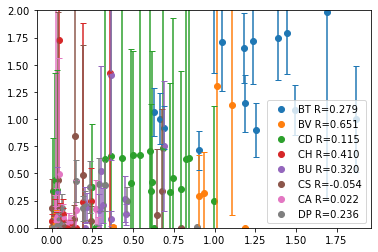

In [6]:
    # save prediction results to a .csv
    strain = file.split("_")[1]
    kfold_df = pd.DataFrame()
    kfold_df['species'] = all_pred_species
    kfold_df['true'] = all_true
    kfold_df['pred'] = all_pred
    kfold_df['stdv'] = all_stdv
    # kfold_df.to_csv(f"kfold/{strain}_kfold.csv", index=False)
        
    # show prediction performance of individual species
    for sp in species:
        sp_inds = all_pred_species == sp
        R = linregress(all_true[sp_inds], all_pred[sp_inds]).rvalue
        plt.scatter(all_true[sp_inds], all_pred[sp_inds], label=f"{sp} " + "R={:.3f}".format(R))
        plt.errorbar(all_true[sp_inds], all_pred[sp_inds], yerr=all_stdv[sp_inds], 
                     fmt='.', capsize=3)
        
    plt.legend()
    plt.ylim([0, 2.])
    plt.show()

In [ ]:
# for file in files:
#     strain = file.split("_")[1]
#     kfold_df = pd.read_csv(f"kfold/{strain}_kfold.csv")
        
#     all_pred_species = kfold_df['species'].values
#     all_true = kfold_df['true'].values 
#     all_pred = kfold_df['pred'].values
#     all_stdv = kfold_df['stdv'].values
        
#     R_overall = linregress(all_true, all_pred).rvalue
        
#     # show prediction performance of individual species
#     for sp in species:
#         sp_inds = all_pred_species == sp
#         R = linregress(all_true[sp_inds], all_pred[sp_inds]).rvalue
#         plt.scatter(all_true[sp_inds], all_pred[sp_inds], label=f"{sp} " + "R={:.3f}".format(R))
#         plt.errorbar(all_true[sp_inds], all_pred[sp_inds], yerr=all_stdv[sp_inds], 
#                      fmt='.', capsize=3)

#     plt.xlabel("Measured OD")
#     plt.ylabel("Predicted OD")
#     plt.legend()
#     plt.title(strain + " R={:.2f}".format(R_overall))
#     plt.show()

# Show fit

In [ ]:
pred_species, true, pred, stdv = predict_df(model, train_df, species)

for sp in species:
    sp_inds = pred_species == sp
    if sum(true[sp_inds]) > 0:
        R = linregress(true[sp_inds], pred[sp_inds]).rvalue
        plt.scatter(true[sp_inds], pred[sp_inds], label=f"{sp} " + "R={:.3f}".format(R))
        plt.errorbar(true[sp_inds], pred[sp_inds], yerr= stdv[sp_inds], 
                     fmt='.', capsize=3)
plt.legend()
plt.show()

In [ ]:
def plot(model, df):

    # pull just the community data
    test_data = process_df(df, species) 

    # plot the results
    for exp, t_span, Y_m, s_present in test_data:

        # increase evaluation time
        t_eval = np.linspace(t_span[0], t_span[-1])

        # predict 
        pred, L, U = model.predict(Y_m, t_eval, log=True)
        
        # un log scale y
        Y_m = np.einsum("ij,j->ij", np.exp(Y_m), s_present)

        plt.figure(figsize=(9, 6))
        for i, s in enumerate(species):
            if Y_m[0,i] > 0:
                plt.scatter(t_span, Y_m[:,i], label="True species " + s, color='C{}'.format(i), marker='o', s=75)
                plt.plot(t_eval, pred[:,i], label="Predicted species " + s, color='C{}'.format(i))
                plt.fill_between(t_eval, L[:,i], U[:,i], color='C{}'.format(i), alpha=0.2)

        plt.legend()
        plt.xlabel("Time", fontsize=16)
        plt.ylabel("Abundance", fontsize=16)
        exp_name, passage_num = exp.split("_")
        plt.title(f"{exp_name} passage {passage_num} predictions")
        # plt.savefig(f"figures/{exp}.png")
        plt.show()

In [ ]:
plot(model, train_df)